# Analyze A/B Test Results 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [References](#references)

<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

<a id='probability'></a>
## Part I - Probability

**To get started, let's import our libraries.**

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

**Read in the dataset from the `ab_data.csv` file and take a look at the top few rows:**

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**The number of rows in the dataset.**

In [3]:
num_rows = len(df)
print(f'The number of rows in the dataset are {num_rows}.')

The number of rows in the dataset are 294478.


**The number of unique users in the dataset.**

In [4]:
unique_users = df['user_id'].unique()
num_users = len(unique_users)
print(f'The number of unique users in the dataset are {num_users}.')

The number of unique users in the dataset are 290584.


**The proportion of users converted.**

In [5]:
total_users = len(df)
converted_users = df[df['converted'] == 1].shape[0]
conv_rate = (converted_users / total_users) * 100
print(f"The proportion of users converted is {conv_rate:.3f}%.")

The proportion of users converted is 11.966%.


**The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.**

In [6]:
group_treatment = len(df[(df['group'] == 'treatment') & (df['landing_page'] != 'new_page')])
print(f'The "group" is treatment but the "landing_page" is not new_page {group_treatment} times.')

The "group" is treatment but the "landing_page" is not new_page 1965 times.


**Are there any missing values?**

In [7]:
if df.isnull().any(axis=1).any():
    print("Some rows have missing values")
else:
    print("No rows have missing values")

No rows have missing values


**<u>In a particular row, the group and landing_page columns should have either of the following acceptable values:<u>**

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  

In [8]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
mask = ((df['group'] == 'control') & (df['landing_page'] == 'old_page')) | ((df['group'] == 'treatment') & (df['landing_page'] == 'new_page'))
df2 = df[mask].copy()

In [9]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

**How many unique `user_id`'s are in df2?**

In [10]:
unique_users = df2['user_id'].unique()
num_users = len(unique_users)
print(f'The number of unique users in the dataset are {num_users}.')

The number of unique users in the dataset are 290584.


**Which `user_id` is repeated in df2?**

In [11]:
duplicates = df2[df2.duplicated(['user_id'], keep=False)]
user_id = duplicates['user_id'].unique()[0]
print(f"The following user_id is repeated in df2 {user_id}.")

The following user_id is repeated in df2 773192.


**Display the rows for the duplicate `user_id`.**

In [12]:
duplicate_user_id = duplicates['user_id'].iloc[0]
duplicate_rows = df2[df2['user_id'] == duplicate_user_id]
print(duplicate_rows)

      user_id                   timestamp      group landing_page  converted
1899   773192  2017-01-09 05:37:58.781806  treatment     new_page          0
2893   773192  2017-01-14 02:55:59.590927  treatment     new_page          0


**Remove ONE of the rows with a duplicate `user_id`, from the df2 dataframe.**

In [13]:
duplicates = df2[df2.duplicated(['user_id'], keep=False)]
df2 = df2.drop(duplicates.index[1])

**What is the probability of an individual converting regardless of the page they receive?**

In [14]:
ppopulation = df2['converted'].mean()
print(f'Probability of converting regardless of page is {ppopulation:.4f}.')

Probability of converting regardless of page is 0.1196.


**Given that an individual was in the `control` group, what is the probability they converted?**

In [15]:
pcontrol = df2[df2['group'] == 'control']['converted'].mean()
print(f'Given that an individual was in the control group, the probability of converting is {pcontrol:.4f}.')

Given that an individual was in the control group, the probability of converting is 0.1204.


**Given that an individual was in the `treatment` group, what is the probability they converted?**

In [16]:
ptreatment = df2[df2['group'] == 'treatment']['converted'].mean()
print(f'Given that an individual was in the treatment group, the probability of converting is {ptreatment:.4f}.')

Given that an individual was in the treatment group, the probability of converting is 0.1188.


In [17]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = (ptreatment - pcontrol)
print(f'The difference between the conversion rates for the two groups is {obs_diff:.2}.')

The difference between the conversion rates for the two groups is -0.0016.


**What is the probability that an individual received the new page?**

In [18]:
pnew_page = (df2['landing_page'] == 'new_page').mean()
print(f'The probability of receiving the new page is {pnew_page:.4f}.')

The probability of receiving the new page is 0.5001.


>**Based of the results there is not enough evidence to suggest that the new treatment group leads to more conversions than the control group. The observed difference in conversion rates between the two groups suggests that the treatment group may have a lower conversion rate than the control group.**

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  

For now, consider you need to make the decision just based on all the data provided.  

If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?

>- $H_0$: $p_{new} - p_{old} \leq 0$
>- $H_1$: $p_{new} - p_{old} > 0$

Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, I will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 

**What is the **conversion rate** for $p_{new}$ under the null hypothesis?**

In [19]:
p_new = ppopulation
print(f'The conversion rate for 𝑝𝑛𝑒𝑤 under the null hypothesis is {p_new:.4f}.')

The conversion rate for 𝑝𝑛𝑒𝑤 under the null hypothesis is 0.1196.


**What is the **conversion rate** for $p_{old}$ under the null hypothesis?**

In [20]:
p_old = ppopulation
print(f'The conversion rate for 𝑝𝑜𝑙𝑑 under the null hypothesis is {p_old:.4f}.')

The conversion rate for 𝑝𝑜𝑙𝑑 under the null hypothesis is 0.1196.


**What is $n_{new}$, the number of individuals in the treatment group?**

In [21]:
n_new = df2[(df2.group == 'treatment') & (df2.landing_page == 'new_page')].shape[0]
print(f'There are {n_new} treatment group users shown the new page.')

There are 145310 treatment group users shown the new page.


**What is $n_{old}$, the number of individuals in the control group?**

In [22]:
n_old = df2[(df2.group == 'control')].shape[0]
print(f'There are {n_old} individuals in the control group.')

There are 145274 individuals in the control group.


**Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>

In [23]:
# Simulate a Sample for the treatment Group    bn 
new_page_converted = np.random.choice([0, 1], size=n_new, p=[1-p_new, p_new])
new_page_converted

array([1, 0, 0, ..., 1, 0, 0])

**Simulate Sample for the `control` Group**
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [24]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([0, 1], size=n_old, p=[1-p_old, p_old])
new_page_converted

array([1, 0, 0, ..., 1, 0, 0])

**Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for the simulated samples.**

In [25]:
prob_new = new_page_converted.mean()
prob_old = old_page_converted.mean()
diff_prob = prob_new - prob_old
print(f"The difference in 'converted' probability is: {diff_prob:.3f}")

The difference in 'converted' probability is: 0.002



**Sampling distribution**

In [26]:
# Sampling distribution 
p_diffs = []
for _ in range(10000):
    new_pg_converted_sim = np.random.binomial(n_new,p_new)/n_new
    old_pg_converted_sim = np.random.binomial(n_old,p_old)/n_old
    diff = new_pg_converted_sim - old_pg_converted_sim 
    p_diffs.append(diff)

**Histogram**<br> 
**A histogram of the **p_diffs** using `plt.axvline()` method to mark the actual difference observed in the `df2` data, in the chart.**

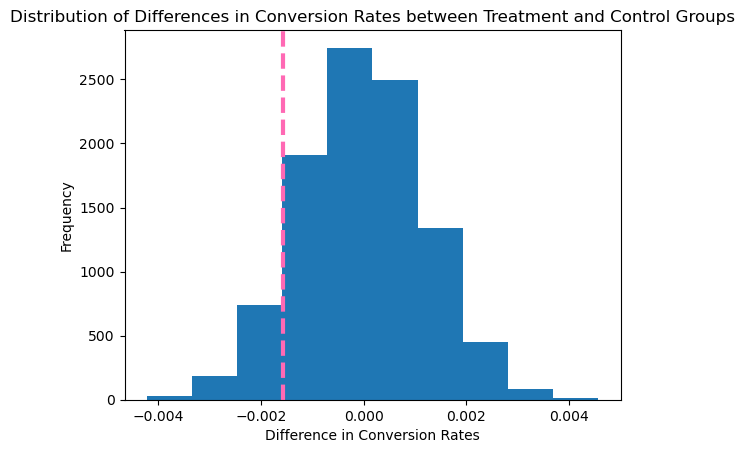

In [27]:
plt.hist(p_diffs)
plt.axvline(obs_diff, color='hotpink', linestyle='dashed', linewidth=3)
plt.title('Distribution of Differences in Conversion Rates between Treatment and Control Groups')
plt.xlabel('Difference in Conversion Rates')
plt.ylabel('Frequency')
plt.show()

**What proportion of the `p_diffs` are greater than the actual difference observed in the `df2` data?**

In [28]:
p_val = (p_diffs > obs_diff).mean()
print(f"The p-value is: {p_val:.3f}")

The p-value is: 0.903


>**Above, I computed the p-value. The p-value is a measure of the evidences strength against the null hypothesis and is used in scientific studies to test hypotheses and make statistical decisions. The p-value I calculated was 0.905, which is greater than the typical Type I error rate of 0.05. Based on this there is not enough evidence to reject the null hypothesis to say that the new page has a higher conversion rate than the old page. The data suggests that the new page does not perform significantly better than the old page in terms of conversion rate.**



**Using Built-in Methods for Hypothesis Testing**<br>
The built in methods for hypothesis testing could also use a built-in to achieve similar results.

- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [29]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query('group == "control" and converted==1').shape[0]

# number of conversions with the new_page
convert_new = df2.query('group=="treatment" and converted==1').shape[0]

# number of individuals who were shown the old_page
n_old = df2.query('group=="control"').shape[0]

# number of individuals who received new_page
n_new = df2.query('group=="treatment"').shape[0]

**Using `sm.stats.proportions_ztest()` to compute your test statistic and p-value.**

In [30]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='larger')
print(z_score, p_value)

1.3109241984234394 0.09494168724097551


>**The z-score and p-value calculated suggest that there is not enough evidence to support the claim that the new page has a higher conversion rate than the old page. This is consistent with the findings from our previous analyses. Therefore, switching to the new page should not be done at this time and the old page should continue to be used until further improvements to increase conversion rates are made.**

<a id='regression'></a>
### Part III - A regression approach

**Since each row in the `df2` data is either a conversion or no conversion, I will be using `Logistic Regression`.**

The goal is to use **statsmodels** library to fit the regression model specified above to see if there is a significant difference in conversion based on the page-type a customer receives. However, I will first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [31]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']

**Using `statsmodels` to instantiate my regression model on the two columns created above, then fit the model to predict whether or not an individual converts.**

In [32]:
logit_model = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**Summary of the model.**

In [33]:
print(results.summary())

                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 06 May 2023   Pseudo R-squ.:               8.077e-06
Time:                        14:41:11   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007


>**The p-value for the "ab_page" in the logistic regression is 0.190. This p-value is different from the one I obtained in Part II because the null and alternative hypotheses are different. Part III is a two-tailed hypothesis test with the null hypothesis that the conversion rate of the new page is equal to the conversion rate of the old page, and the alternative hypothesis that the conversion rate of the new page is not equal to the conversion rate of the old page. This returned a p-value of 0.190. 0.190 is still larger than the significance level of 0.05. That there is not enough evidence to suggest that the new page has a higher conversion rate than the old page.**

**Other factors may influence whether or not an individual converts.**

>**It is a good idea to consider other factors that might influence conversion rates and add them as predictor variables in the regression model to improve its accuracy and increase understanding. However, adding too many variables can make it difficult to interpret the results. Therefore, it is important to carefully choose which variables to include.**

**Adding countries**<br>
**I will look at the individual factors of country and page on conversion.**

In [34]:
# Read the countries.csv
countries_df = pd.read_csv('countries.csv')

In [35]:
# Join with the df2 dataframe
df_merged = pd.merge(df2, countries_df, on='user_id', how='inner')

In [36]:
# Create the necessary dummy variables
df_merged[['UK', 'US', 'CA']] = pd.get_dummies(df_merged['country'])

In [37]:
logit_model = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'CA', 'UK']])
results = logit_model.fit()

print(results.summary())

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sat, 06 May 2023   Pseudo R-squ.:               2.323e-05
Time:                        14:41:12   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9794      0.013   -155.415      0.000      -2.004      -1.954
ab_page       -0.0149      0.

>**It does not appear that country had an impact on conversion. P-values are not of significat value. The p-value associated with either country did not have a significant impact on conversion rates. There is not enough evidence to say for sure that the country where the user is located has an impact on conversion rates. Further investigation and data would be needed to determine if there are other factors that may be influencing conversion rates.**

**Though I have looked at the individual factors of country and page on conversion, I would now like to look at an interaction between page and country to see if are there significant effects on conversion.**

In [38]:
df_merged['UK_ab_page'] = df_merged['UK']*df_merged['ab_page']
df_merged['CA_ab_page'] = df_merged['CA']*df_merged['ab_page']

logit_mod = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'UK', 'CA', 'UK_ab_page', 'CA_ab_page']])
results = logit_mod.fit()

print(results.summary())

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sat, 06 May 2023   Pseudo R-squ.:               3.482e-05
Time:                        14:41:13   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9922      0.016   -123.457      0.000      -2.024      -1.961
ab_page        0.0108      0.

>**It does not appear that country had an impact on conversion. P-values are not of significat value. The p-value associated with the "ab_page" is also not significant at the 0.05 level. Therefore, based on this logistic regression model, it appears that the country did not have a significant impact on conversion rates. The new page is performing similarly to the old page across countries tested. Based on these results country-specific factors do not need to be considered when making a decision on whether to adopt the new page.**

>**There is also not enough evidence to say for sure that the new page is better than the old page or that the country where the user is located has an impact on conversion rates. Further investigation and data would be needed to determine if there are other factors that may be influencing conversion rates.**




<a id='references'></a>
## References

>- **GeorgiGeorgiev-Geo. (2022, February 25). Statistical Significance in A/B Testing – a Complete Guide. Blog for Web Analytics, Statistics and Data-Driven Internet Marketing | Analytics-Toolkit.com. https://blog.analytics-toolkit.com/2017/statistical-significance-ab-testing-complete-guide/**

>- **Knowledge - Udacity. (n.d.). https://knowledge.udacity.com/?nanodegree=nd002-wgu**

>- **McMillen, J. (2020). A/B Testing Statistics: An Intuitive Guide For Non-Mathematicians. Conversion Sciences. https://conversionsciences.com/ab-testing-statistics/**

>- **pandas.DataFrame.join — pandas 2.0.1 documentation. (n.d.). https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html**

>- **Udacity. (2016, June 6). A/B Testing [Video]. YouTube. https://www.youtube.com/watch?v=8H6QmMQWPEI**